In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
from datasets import Dataset
import data
from os.path import join as oj
import pickle as pkl
import os
import utils

# Let's look at the results
These are the results for when we just query the model to ask it the relationship after few-shot prompting with a single example.

In [115]:
def load_results_and_cache(results_dir):
    dir_names = sorted([fname
                        for fname in os.listdir(results_dir)
                        if os.path.isdir(oj(results_dir, fname))
                        and os.path.exists(oj(results_dir, fname, 'results_final.pkl'))
                        ])
    results_list = []
    for dir_name in tqdm(dir_names):
        try:
            ser = pd.Series(
                pkl.load(open(oj(results_dir, dir_name, 'results_final.pkl'), "rb")))
            # only keep scalar-valued vars
            ser_scalar = ser[~ser.apply(
                lambda x: isinstance(x, list)).values.astype(bool)]
            results_list.append(ser_scalar)
        except:
            print('skipping', dir_name)

    r = pd.concat(results_list, axis=1).T.infer_objects()
    r.to_pickle(os.path.join(results_dir, 'r.pkl'))


def postprocess_results(r):
    """
    # drop some things to make it easier to see
    cols = r.columns
    cols_to_drop = [k for k in cols
                    if k.endswith('prefix') or k.endswith('init') # or k.startswith('use')
                    ]
    cols_to_drop += ['epoch_save_interval', 'batch_size']
    r = r.drop(columns=cols_to_drop)
    """

    r['final_answer_found'] = (~r['final_answer_full'].isna()).astype(int)
    return r


cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']


Load results

In [179]:
dir_single_query = '/home/chansingh/mntv1/single_query6'
# r = load_results_and_cache(results_dir)
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = postprocess_results(r_single_query)


dir_suffix_search = '/home/chansingh/mntv1/sweep_morning2'
# r_suffix_search = load_results_and_cache(results_dir)
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = postprocess_results(r_suffix_search)

100%|██████████| 82/82 [00:06<00:00, 13.17it/s]


skipping Sep_03_21_54_llpffnttldqf


100%|██████████| 82/82 [00:00<00:00, 1201.60it/s]


skipping Sep_03_21_54_llpffnttldqf


Plot relevant results

In [190]:
def num_suffixes_checked_tab(tab):
    return (tab
            # mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots'])['final_num_suffixes_checked', 'use_single_query']
            .mean()
            .reset_index()
            )
tab_single_query = num_suffixes_checked_tab(r_single_query)
tab_suffix_search = num_suffixes_checked_tab(r_suffix_search)
tab = pd.concat((tab_single_query, tab_suffix_search)).sort_values('checkpoint')
tab['use_single_query'] = tab['use_single_query'].astype(bool)

/tmp/ipykernel_180142/3726263579.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab
/tmp/ipykernel_180142/3726263579.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab


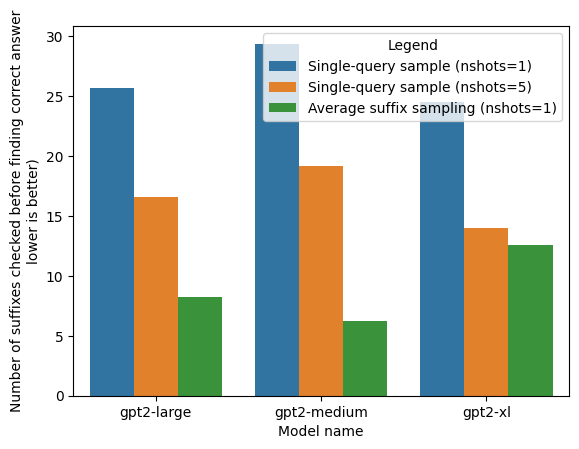

In [192]:
# tab[' '] = tab['use_single_query'].map(VALS) # hacky fix to get legend to automatically work
VALS = {
    True: 'Single-query sample',
    False: 'Average suffix sampling',
}
tab['Legend'] = tab['use_single_query'].map(VALS) + ' (nshots=' + tab['n_shots'].astype(str) + ')'
sns.barplot(x='checkpoint', y='final_num_suffixes_checked', hue='Legend', data=tab) #data=tab[tab['n_shots'] == 1])
plt.xlabel('Model name')
plt.ylabel('Number of suffixes checked before finding correct answer\nlower is better)')
plt.show()

# look at some of the tables

In [119]:
cols_to_view = r_single_query.columns # cols_to_view

In [106]:
r_single_query.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_answer_found  final_model_queries  \
checkpoint  n_shots                                            
gpt2-large  1                      1.00                46.84   
            5                      1.00                13.75   
gpt2-medium 1                      1.00                83.82   
            5                      1.00                22.88   
gpt2-xl     1                      1.00                57.44   
            5                      0.98                10.92   

                     final_num_suffixes_checked  
checkpoint  n_shots                              
gpt2-large  1                             25.62  
            5                             16.58  
gpt2-medium 1                             29.36  
            5                             19.12  
gpt2-xl     1                             24.47  
            5                             14.00

In [107]:
r_single_query.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates

final_answer_found  final_model_queries  \
checkpoint  n_shots task_name                                               
gpt2-large  1       add_two                     1.00                 1.33   
                    divide_two                  1.00                 3.00   
                    max_two                     1.00               219.89   
                    multiply_two                1.00                 3.67   
                    subtract_two                1.00                 6.33   
            5       add_two                     1.00                 1.33   
                    divide_two                  1.00                 1.33   
                    max_two                     1.00               115.00   
                    multiply_two                1.00                 1.33   
                    subtract_two                1.00                 6.00   
gpt2-medium 1       add_two                     1.00                 3.11   
                    divide_two                  1.00                 1.33   
                    max_two                     1.00               388.33   
                    multiply_two                1.00                 1.33   
                    subtract_two                1.00                25.00   
            5       add_two                     1.00                 1.22   
                    divide_two                  1.00                 1.33   
                    max_two                     1.00               207.75   
                    multiply_two                1.00                 1.33   
                    subtract_two                1.00                 5.44   
gpt2-xl     1       add_two                     1.00                 2.33   
                    divide_two                  1.00                 6.67   
                    max_two                     1.00               267.78   
                    multiply_two                1.00                 1.33   
                    subtract_two                1.00                 9.11   
            5       add_two                     1.00                 1.33   
                    divide_two                  1.00                 4.56   
                    max_two                     0.75                97.00   
                    multiply_two                1.00                 1.33   
                    subtract_two                1.00                 7.78   

                                  final_num_suffixes_checked  
checkpoint  n_shots task_name                                 
gpt2-large  1       add_two                             6.00  
                    divide_two                          8.22  
                    max_two                            86.33  
                    multiply_two                        9.67  
                    subtract_two                       17.89  
            5       add_two                             4.89  
                    divide_two                          6.78  
                    max_two                            92.50  
                    multiply_two                        6.11  
                    subtract_two                       14.78  
gpt2-medium 1       add_two                             8.44  
                    divide_two                          6.00  
                    max_two                           100.89  
                    multiply_two                        4.89  
                    subtract_two                       26.56  
            5       add_two                             7.22  
                    divide_two                          4.67  
                    max_two                           103.75  
                    multiply_two                        4.22  
                    subtract_two                       22.78  
gpt2-xl     1       add_two                            12.11  
                    divide_two                         17.44  
                    max_two                            64

In [116]:
r_suffix_search.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

,,final_answer_found,final_model_queries,final_num_suffixes_checked
checkpoint,n_shots,,,
gpt2-large,1,1.0,2.70,8.26
gpt2-medium,1,1.0,1.93,6.22
gpt2-xl,1,1.0,2.93,12.56


In [120]:
r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates, task_name

max_digit  n_shots  \
checkpoint  n_shots task_name                          
gpt2-large  1       add_two            10.0      1.0   
                    divide_two         10.0      1.0   
                    multiply_two       10.0      1.0   
gpt2-medium 1       add_two            10.0      1.0   
                    divide_two         10.0      1.0   
                    multiply_two       10.0      1.0   
gpt2-xl     1       add_two            10.0      1.0   
                    divide_two         10.0      1.0   
                    multiply_two       10.0      1.0   

                                  template_num_init_string  \
checkpoint  n_shots task_name                                
gpt2-large  1       add_two                            1.0   
                    divide_two                         1.0   
                    multiply_two                       1.0   
gpt2-medium 1       add_two                            1.0   
                    divide_two                         1.0   
                    multiply_two                       1.0   
gpt2-xl     1       add_two                            1.0   
                    divide_two                         1.0   
                    multiply_two                       1.0   

                                  template_num_task_phrasing  max_num_tokens  \
checkpoint  n_shots task_name                                                  
gpt2-large  1       add_two                              1.0             4.0   
                    divide_two                           1.0             4.0   
                    multiply_two                         1.0             4.0   
gpt2-medium 1       add_two                              1.0             4.0   
                    divide_two                           1.0             4.0   
                    multiply_two                         1.0             4.0   
gpt2-xl     1       add_two                              1.0             4.0   
                    divide_two                           1.0             4.0   
                    multiply_two                         1.0             4.0   

                                  lr_prefix  beam_width_suffix  \
checkpoint  n_shots task_name                                    
gpt2-large  1       add_two             0.0                5.0   
                    divide_two          0.0                5.0   
                    multiply_two        0.0                5.0   
gpt2-medium 1       add_two             0.0                5.0   
                    divide_two          0.0                5.0   
                    multiply_two        0.0                5.0   
gpt2-xl     1       add_two             0.0                5.0   
                    divide_two          0.0                5.0   
                    multiply_two        0.0                5.0   

                                  use_single_query  batch_size  seed  \
checkpoint  n_shots task_name                                          
gpt2-large  1       add_two                    0.0       100.0   1.0   
                    divide_two                 0.0       100.0   1.0   
                    multiply_two               0.0       100.0   1.0   
gpt2-medium 1       add_two                    0.0       200.0   1.0   
                    divide_two                 0.0       200.0   1.0   
                    multiply_two               0.0       200.0   1.0   
gpt2-xl     1       add_two                    0.0        40.0   1.0   
                    divide_two                 0.0        40.0   1.0   
                    multiply_two               0.0        40.0   1.0   

                                  n_epochs_prefix  use_cpu_only  \
checkpoint  n_shots task_name                                     
gpt2-large  1       add_two               10000.0           0.0   
                    divide_two            10000.0           0.0   
                    multiply_two          10000.0           0.0  

# look at individual results

In [ ]:
results_dir = '/home/chansingh/mntv1/sweep0/Sep_02_21_24_zjpbgvrtlohx'
r = pkl.load(open(oj(results_dir, 'results_final.pkl'), 'rb'))
print(r)